# Sifting through results of the parameter search
This notebook searches the experiment brute-forced in notebook D1, looking for networks that 'stably' propagate spike pulses.

Specifically, the criteria for 'stable' spike pulse propagation are:
1. Spikes occur in the final link of the chain OR there is spiking activity is still ongoing as the simulation ends.
2. The mean number of spike counts per link is greater than (5 * number of neurons per link) and less than (7 * number of neurons per link).
3. The standard derivation of spike counts per link is less than 30% of the mean spike count per link.
4. The standard deviation of the standard derivation of spike times per link is less than 30% of the mean of the standard deviation of spike times per link.

## Hyperparameters

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [2]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
import datetime
import os
import pandas as pd

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

from utils.general import *
from utils.file_io import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=1.6e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.05e-3,  # I->E input weights
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s)) 
    I_EXT_B=0,  # additional baseline current input
)

# Code
### Define helper functions that determine whether networks meet given criteria

In [3]:
# compute the spikes times for given link labeled by 'idx' given the results of a particular simulation
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

# compute the spike times for all links given the results of a particular simulation
def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

# identify the time of the last spike in a simulation given the spike times for each link
def last_spk_tm(tms_p_link):
    l = len(tms_p_link)
    for i in range(l):
        tms_for_link = tms_p_link[l - i - 1]
        if len(tms_for_link) > 0:
            return tms_for_link[-1]

### Define functions for loading and scanning experiments for interesting results by batch

In [44]:
# generator that takes the path to batch of experiments, and yields the data from each batch, one batch at a time
def load_batches(batch_path):
    fs = [f for f in sorted(all_files_with_name_frags(batch_path, 'batch_'))]
    for f_idx, f in enumerate(fs):
        batch_data = pickle.load(open(os.path.join(batch_path, f), 'rb'))
        yield batch_data

# determine if a single experiment meets criteria for stable propagation behavior
def process_single_exp(experiment_results, m):
    x = np.arange(m.N_L) + 1
    results = []
    
    # for these experiments that determine stable propagation behavior without inhibition,
    # we can ignore simulations with different UVA frequences
    experiment_results = experiment_results[0] if type(experiment_results) is list else experiment_results

    # compute the spk times for each link, and statistics on those times
    tms_p_link = tms_for_link(experiment_results['spks_t'], experiment_results['spks_c'], m.N_L, m.N_L_E)
    mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
    std_tms_p_link = np.array([np.std(tms_for_link) for tms_for_link in tms_p_link])

    mean_of_std = np.mean(std_tms_p_link[~np.isnan(std_tms_p_link)])
    std_of_std = np.std(std_tms_p_link[~np.isnan(std_tms_p_link)])

    # compute statistics on spike counts
    counts_per_link = np.array(map_to_list(lambda l: l.size, tms_p_link))
    mean_cnts_p_link = np.mean(counts_per_link[counts_per_link > 0])
    std_cnts_p_link = np.std(counts_per_link[counts_per_link > 0])

    # determine if simulation (and therefore parameters) meet filtration criteria
    if ((len(tms_p_link[-1]) == 0 and (last_spk_tm(tms_p_link) < (.3 - 0.01))) # criterion 1
        or std_of_std / mean_of_std > 0.3 # criterion 4
        or std_cnts_p_link / mean_cnts_p_link > 0.3 # criterion 3
        or mean_cnts_p_link > 7 * m.N_L_E # criterion 2
        or mean_cnts_p_link < 5 * m.N_L_E):
        return None
    
    # fit a linear function to the mean times per link
    slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]
    return [mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link]

# in the event that we conduct repeat simulations for a single set of parameters, the function 
# handles the processing each individual experiment by feeding it into 'process_single_exp'
def parse_param_results(all_results_for_params, m):
    if type(all_results_for_params[0]) is list:
        l = len(all_results_for_params)
        processed = [process_single_exp(res, m) for res in all_results_for_params]
        for el in processed:
            if el is None: 
                return None # if any of the experiments for a particular set of parameters do not meet given criteria,
                            # neglect the params entirely
        return processed
    else:
        processed = process_single_exp(all_results_for_params, m)
        if processed is not None:
            return [processed]
        
# process all the experiments and repeats trials within a single batch
# experiments were written in batches to not overwhelm the available memory
def scan_batch(batch_results, batch_params, m, batch_idx):
    x = np.arange(m.N_L) + 1
    passing_scan = [] # parameters and their accompanying simulations that meet the given criteria 

    # sift through all the experiments in the batch
    for r in zip(batch_results, batch_params):
        (all_results_for_params, params) = r
        processed = parse_param_results(all_results_for_params, m)
        if processed is not None:
            passing_scan.append((params, processed))

    return passing_scan

    # below is functionality for graphing the params that meet criteria
#     for idx, (params, processed) in enumerate(passing_scan):
#         print(params)
        
#         (mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link) = processed[0]
#         gs = gridspec.GridSpec(2, 1)
#         fig = plt.figure(figsize=(10, 10), tight_layout=True)
#         axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
#         axs[0].set_title(f'index: {batch_idx}{idx} params:' + ' '.join(map_to_list(lambda p_i: f'{p_i}', params)))
#         axs[0].fill_between(x, mean_tms_p_link - std_tms_p_link, mean_tms_p_link + std_tms_p_link, color='red', alpha=0.25)
#         axs[0].scatter(x, mean_tms_p_link, s=3, c='red')
#         axs[0].set_ylim(0, 0.3)
#         axs[0].set_xlim(0, m.N_L)

#         for l_cntr in range(m.N_L):
#             y = l_cntr * np.ones(len(tms_p_link[l_cntr])) + 1
#             axs[1].scatter(tms_p_link[l_cntr], y + .2 * np.random.randn(len(y)), s=5, c='black', zorder=0)
#             axs[1].set_ylim(0, m.N_L)
#         print('')


# Graphing stable networks
Iterate through all experiments, identifying stable network params. Then, graph each stable network as a function of its recurrent and feed-forward weights. Create a separate graph for each intralink connectivity percentage.

In [65]:
def graph_stable_networks(batch_path):
    params = pickle.load(open(os.path.join(batch_path, 'params.p'), 'rb'))
    config = pickle.load(open(os.path.join(batch_path, 'config.p'), 'rb'))
    results_meeting_criteria = []
    
    for batch_idx, batch_data in enumerate(load_batches(batch_path)):
        batch_start = batch_idx * config['batch_size']
        batch_end = np.min([batch_start + config['batch_size'], len(params)])
        results_meeting_criteria.append(scan_batch(batch_data, params[batch_start:batch_end], M, batch_idx))
    
    data = {'weer': [], 'weef': [], 'cxneep': []}
    
    for batch in results_meeting_criteria:
        if len(batch) is not 0:
            params = batch[0][0]
            data['weer'].append(params[2])
            data['weef'].append(params[3])
            data['cxneep'].append(params[5])

    df = pd.DataFrame(data=data)
    print(df)
    
    pd.set_option('display.max_rows', 500)

    for cxn in sorted(df['cxneep'].unique()):
        df_for_cxn = df[df['cxneep'] == cxn]
        print(cxn)
        print(df_for_cxn)

        pickle.dump(df_for_cxn, open(os.path.join(batch_path, f'stable_weights_per_{str(cxn)[2:5]}.p'), 'wb'))

        gs = gridspec.GridSpec(1, 1)
        fig = plt.figure(figsize=(10, 10), tight_layout=True)
        ax = fig.add_subplot(gs[0])
        ax.scatter(df_for_cxn['weer'], df_for_cxn['weef'])

        ax.set_ylim(0.1e-6, 15.0e-6)
        ax.set_ylabel('Exc -> Exc Feed-Forward Weight')
        ax.set_xlim(0.1e-6, 15.0e-6)
        ax.set_xlabel('Exc -> Exc Recurrent Weight')
        ax.set_title(f'{cxn}')

             weer      weef  cxneep
0    1.000000e-07  0.000010    0.21
1    1.000000e-07  0.000011    0.08
2    2.505051e-07  0.000010    0.47
3    2.505051e-07  0.000011    0.08
4    4.010101e-07  0.000010    0.60
5    4.010101e-07  0.000011    0.21
6    5.515152e-07  0.000010    0.60
7    5.515152e-07  0.000011    0.34
8    7.020202e-07  0.000010    0.47
9    7.020202e-07  0.000011    0.08
10   8.525253e-07  0.000010    0.21
11   8.525253e-07  0.000011    0.08
12   1.003030e-06  0.000010    0.60
13   1.003030e-06  0.000011    0.08
14   1.153535e-06  0.000010    0.47
15   1.153535e-06  0.000011    0.21
16   1.304040e-06  0.000010    0.47
17   1.304040e-06  0.000011    0.34
18   1.454545e-06  0.000009    0.60
19   1.454545e-06  0.000011    0.08
20   1.605051e-06  0.000011    0.60
21   1.605051e-06  0.000012    0.08
22   1.755556e-06  0.000011    0.47
23   1.755556e-06  0.000012    0.08
24   1.906061e-06  0.000011    0.60
25   1.906061e-06  0.000012    0.08
26   2.056566e-06  0.000011 

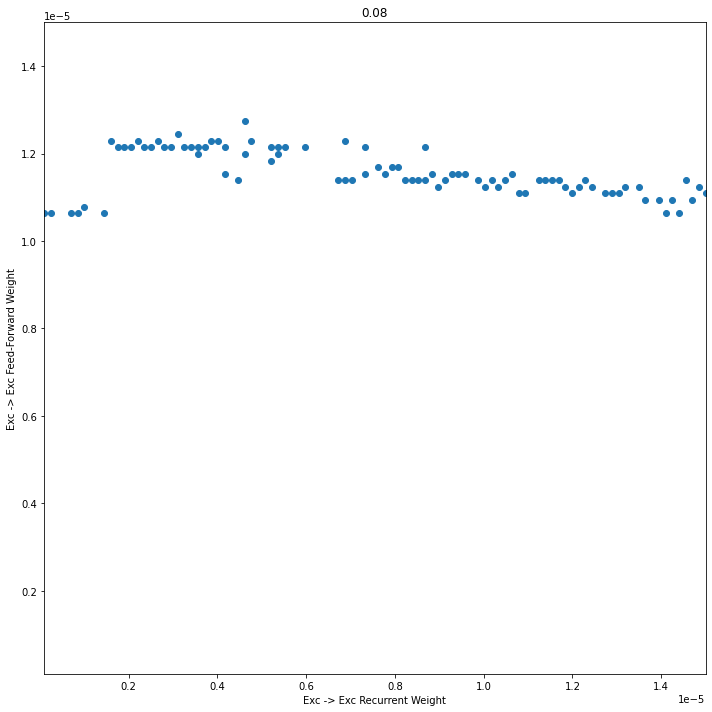

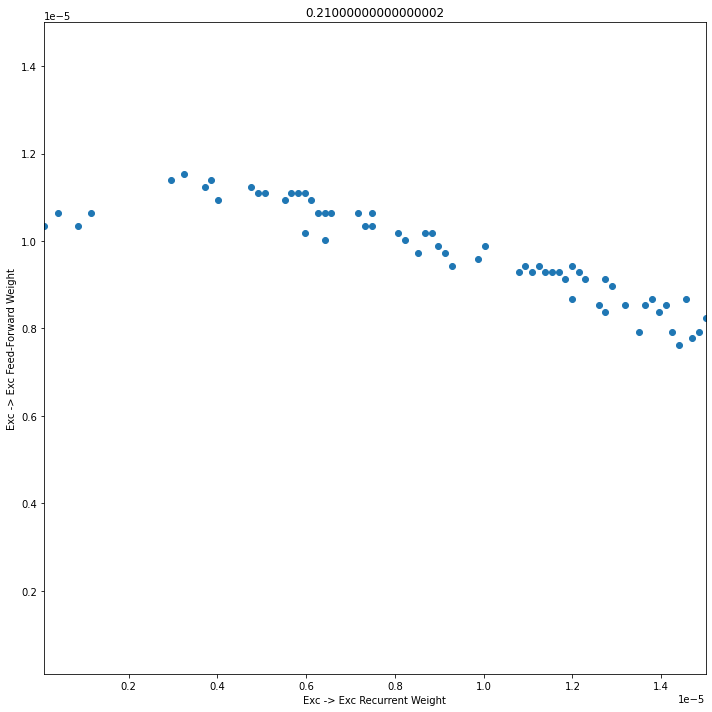

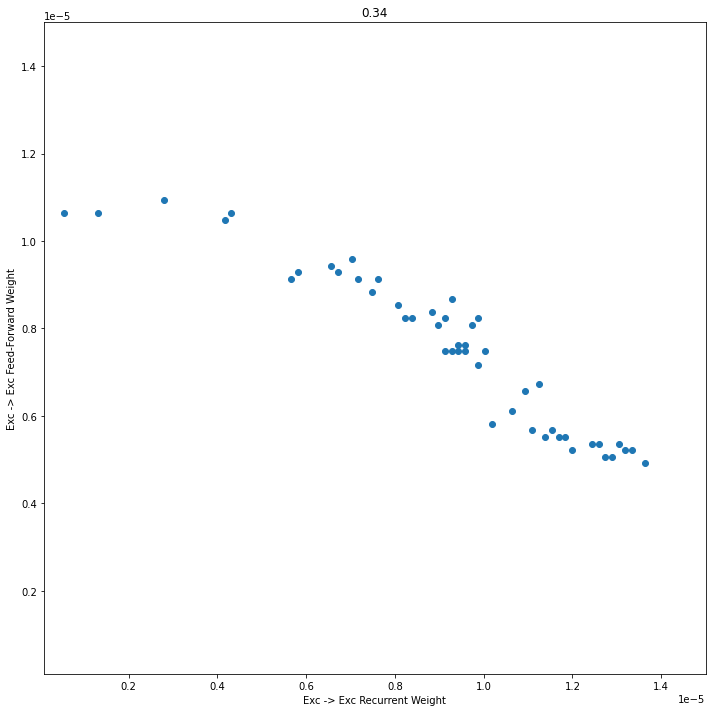

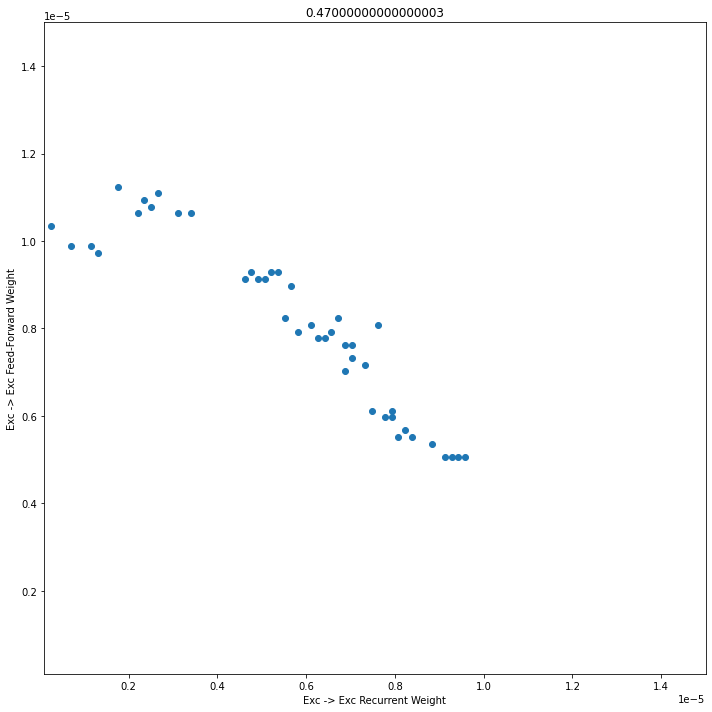

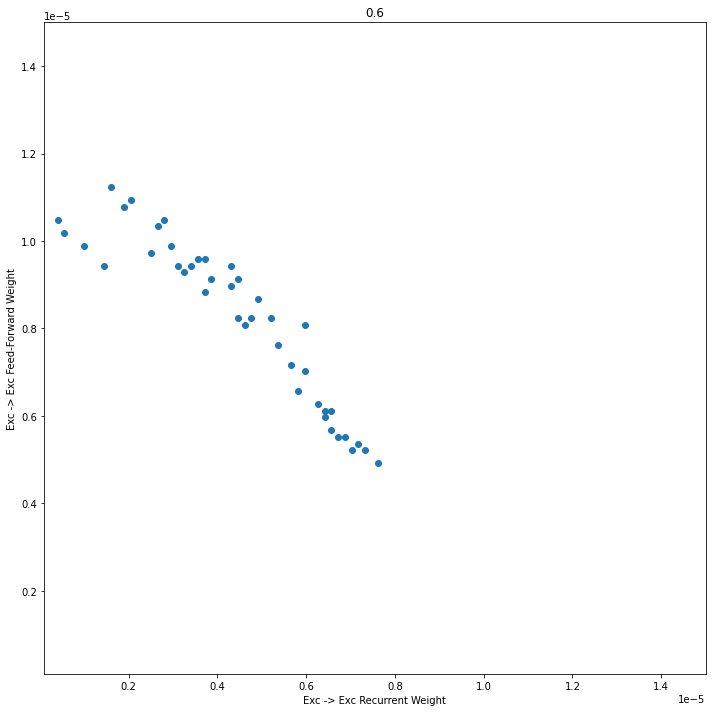

In [66]:
graph_stable_networks('./data/exp_2020-07-01--13:42')

In [ ]:
graph_stable_networks('./data/exp_2020-07-06--22:54')